# PBO learnt on one iteration and two weigths

## Define paramters

In [28]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 1
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Box over states and actions
max_discrete_state = 7
n_discrete_states = 5
max_discrete_action = 9
n_discrete_actions = 7

gamma = 1

# Q function
layer_dimension = 50
action_range_on_max = 2 * max_discrete_action
n_actions_on_max = 1000

# PBO trainings
max_iterations = 10000
batch_size_samples = 1
batch_size_weights = 1
learning_rate = 0.0001

# Visualisation
plot_freq = 200
sleeping_time = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define environment

In [29]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = -0.5264108180999756s + 0.7340433597564697a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.9019700288772583s² + 0.12905049324035645a² + 0.4164412021636963sa


## Collect samples

### Epsilon greedy from optimal actions

In [30]:
# from pbo.data_collection.replay_buffer import ReplayBuffer


# replay_buffer = ReplayBuffer()

# state = env.reset()
# idx_sample = 0
# epidose_length = 0

# while idx_sample < n_samples:
#     greedy_key, key = jax.random.split(greedy_key)
#     if jax.random.uniform(key) < epsilon_greedy:
#        action = env.optimal_action()
#     else:
#         greedy_key, key = jax.random.split(greedy_key)
#         action = jax.random.uniform(key, [env.B.shape[0]], minval=discrete_actions[0], maxval=discrete_actions[-1])
#     next_state, reward, _, _ = env.step(action)

#     replay_buffer.add(state, action, reward, next_state)

#     epidose_length += 1
#     idx_sample += 1

#     if epidose_length >= max_episode_length:
#         state = env.reset()
#         epidose_length = 0
#     else:    
#         state = next_state

### Samples on the crosses of the box

In [31]:
import jax.numpy as jnp

from pbo.data_collection.replay_buffer import ReplayBuffer


n_samples = n_discrete_states * n_discrete_actions
replay_buffer = ReplayBuffer()

state = env.reset()
idx_sample = 0
epidose_length = 0

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

## Visualize samples

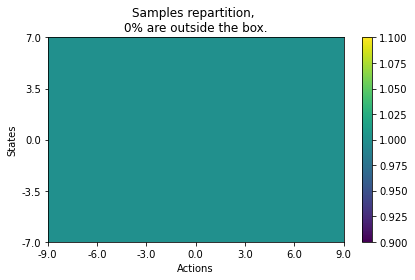

In [32]:
from pbo.data_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, discrete_states_boxes, discrete_actions_boxes)
samples_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Build q network

In [33]:
from pbo.networks.jax.q import FullyConnectedQ


q = FullyConnectedQ(
    layer_dimension=layer_dimension,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    action_range_on_max=action_range_on_max,
    n_actions_on_max=n_actions_on_max,
)

## Build PBO network and its dataloader

In [34]:
from pbo.networks.jax.pbo import LinearPBO
from pbo.sample_collection.dataloader import SampleDataLoader


pbo = LinearPBO(pbo_network_key, gamma, q)

replay_buffer.cast_to_jax_array()
data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)

## Train PBO on one iteration over one random init weight

### Define the two random init weights and its iterated versions

In [35]:
from pbo.weights_collection.dataloader import WeightsDataLoader


full_batch = {
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}

random_q_weights_1 = q.random_init_weights()
random_q_params_1 = q.to_params(random_q_weights_1)
target_discrete_iterated_q_1 = pbo.compute_target(full_batch, random_q_weights_1.reshape(1, -1)).reshape((n_discrete_states, n_discrete_actions))

random_q_weights_2 = q.random_init_weights()
random_q_params_2 = q.to_params(random_q_weights_2)
target_discrete_iterated_q_2 = pbo.compute_target(full_batch, random_q_weights_2.reshape(1, -1)).reshape((n_discrete_states, n_discrete_actions))

data_loader_weights = WeightsDataLoader(jnp.vstack((random_q_weights_1, random_q_weights_2)), batch_size_weights, shuffle_key)

### Training

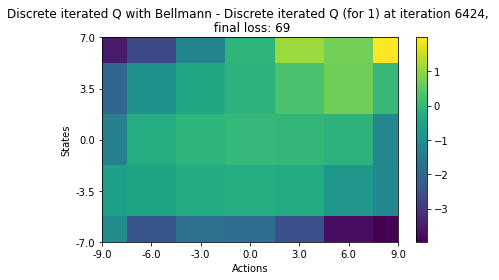

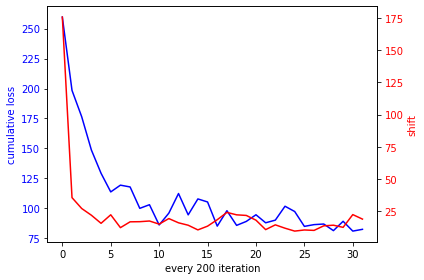

In [36]:
import matplotlib.pyplot as plt

import optax


optimizer = optax.sgd(learning_rate=learning_rate)
optimizer_state = optimizer.init(pbo.params)

# For visualization
q_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time)
former_discrete_iterated_q_1 = q.discretize(random_q_params_1, discrete_states, discrete_actions)
former_discrete_iterated_q_2 = q.discretize(random_q_params_2, discrete_states, discrete_actions)
cumulative_losses = []
shifts = []

iteration = 0
cumulative_loss = float("inf")

while cumulative_loss > 2 * n_discrete_states * n_discrete_actions and iteration < max_iterations:
    cumulative_loss = 0
    
    data_loader_weights.shuffle()
    for batch_weights in data_loader_weights:
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            target = pbo.compute_target(batch_samples, batch_weights)

            loss, grad_loss = pbo.loss_and_grad(pbo.params, batch_samples, batch_weights, target)
            updates, optimizer_state = optimizer.update(
                grad_loss, optimizer_state
            )
            pbo.params = optax.apply_updates(pbo.params, updates)

            cumulative_loss += loss

    iteration += 1

    # Visualization
    if iteration % plot_freq == 0:
        iterated_q_weigths = pbo.network.apply(pbo.params, random_q_weights)
        # Q.discretize_several
        discrete_iterated_q_1 = q.discretize(q.to_params(iterated_q_weigths[0]), discrete_states, discrete_actions)
        discrete_iterated_q_2 = q.discretize(q.to_params(iterated_q_weigths[1]), discrete_states, discrete_actions)
        
        shift = np.linalg.norm(discrete_iterated_q_1 - former_discrete_iterated_q_1)
        shift += np.linalg.norm(discrete_iterated_q_2 - former_discrete_iterated_q_2)
        shift /= 2

        q_visu_mesh.set_values(target_discrete_iterated_q_1 - discrete_iterated_q_1)
        q_visu_mesh.show(f"Discrete iterated Q with Bellmann - Discrete iterated Q (for 1) at iteration {iteration}, \nloss: {int(cumulative_loss)}, shift: {np.around(shift, 2)}")
        
        cumulative_losses.append(cumulative_loss)
        shifts.append(shift)
        former_discrete_iterated_q_1 = discrete_iterated_q_1
        former_discrete_iterated_q_2 = discrete_iterated_q_2

iterated_q_weigths = pbo.network.apply(pbo.params, random_q_weights)
final_discrete_iterated_q_1 = q.discretize(q.to_params(iterated_q_weigths[0]), discrete_states, discrete_actions)
final_discrete_iterated_q_2 = q.discretize(q.to_params(iterated_q_weigths[1]), discrete_states, discrete_actions)

q_visu_mesh.set_values(target_discrete_iterated_q_1 - final_discrete_iterated_q_1)
q_visu_mesh.show(f"Discrete iterated Q with Bellmann - Discrete iterated Q (for 1) at iteration {iteration}, \n final loss: {int(cumulative_loss)}")

# Plot the shifts and the loss
fig, ax1 = plt.subplots()

ax1.set_xlabel(f"every {plot_freq} iteration")
ax1.set_ylabel("cumulative loss", color="blue")
ax1.plot(np.arange(len(cumulative_losses)), cumulative_losses, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("shift", color="red")
ax2.plot(np.arange(len(shifts)), shifts, color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.show()